## 1. Loading the Model

In [28]:
import json
import torch
import copy
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, random_split, DataLoader, Subset
from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import AutoTokenizer, RobertaForSequenceClassification, AdamW

import matplotlib.pyplot as plt

In [2]:
# # Load model directly
# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large")
# model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-large", num_labels=3)

In [3]:
# model.save_pretrained("./saved_roberta_model")
# tokenizer.save_pretrained("./saved_roberta_model")

In [4]:
# tokenizer = AutoTokenizer.from_pretrained("./saved_roberta_model")
# model = RobertaForSequenceClassification.from_pretrained("./saved_roberta_model", torch_dtype=torch.float16, device_map="cuda")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.save_pretrained("./saved_roberta_base_model")
tokenizer.save_pretrained("./saved_roberta_base_model")

('./saved_roberta_base_model\\tokenizer_config.json',
 './saved_roberta_base_model\\special_tokens_map.json',
 './saved_roberta_base_model\\vocab.json',
 './saved_roberta_base_model\\merges.txt',
 './saved_roberta_base_model\\added_tokens.json',
 './saved_roberta_base_model\\tokenizer.json')

In [7]:
tokenizer = AutoTokenizer.from_pretrained("./saved_roberta_base_model")
model = RobertaForSequenceClassification.from_pretrained("./saved_roberta_base_model", torch_dtype=torch.float16, device_map="cuda")

## 2. Preparing Training Data

In [8]:
# === Load Labeled JSON ===
with open("data/labeled_sample_sentences.json", "r", encoding="utf-8") as f:
    labeled_data = json.load(f)

In [9]:
# === Flatten & Filter Sentences ===
label_map = {"Hawkish": 0, "Dovish": 1, "Neutral": 2}
sentences, labels = [], []

for entry in labeled_data:
    for sentence in entry["labeled_sentences"]:
        label = sentence["label"]
        if label in label_map:
            sentences.append(sentence["sentence"])
            labels.append(label_map[sentence["label"]])

print(f"Total sentences: {len(sentences)}")
print(f"Label distribution: {pd.Series(labels).value_counts().sort_index()}")

# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

Total sentences: 5819
Label distribution: 0     991
1    1277
2    3551
Name: count, dtype: int64


In [10]:
def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )

In [11]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5819 [00:00<?, ? examples/s]

In [12]:
# === Balance Classes BEFORE tensor conversion ===
df_full = tokenized_dataset.to_pandas()

# Check class distribution
print("Original class distribution:")
print(df_full['label'].value_counts().sort_index())

# Sample equal amounts from each class (use minimum class size or a reasonable number)
min_samples = min(df_full['label'].value_counts())
target_samples = min(min_samples, 991)  # Don't exceed available samples

print(f"Sampling {target_samples} from each class...")

neutral_df = df_full[df_full['label'] == 2].sample(n=target_samples, random_state=42)
hawkish_df = df_full[df_full['label'] == 0].sample(n=target_samples, random_state=42)
dovish_df = df_full[df_full['label'] == 1].sample(n=target_samples, random_state=42)

balanced_df = pd.concat([hawkish_df, dovish_df, neutral_df])
balanced_df = balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_df['label'].value_counts().sort_index())

Original class distribution:
label
0     991
1    1277
2    3551
Name: count, dtype: int64
Sampling 991 from each class...
Balanced class distribution:
label
0    991
1    991
2    991
Name: count, dtype: int64


In [13]:
# === Convert to PyTorch tensors (ONLY ONCE) ===
input_ids = np.array(list(balanced_df["input_ids"]))
attention_mask = np.array(list(balanced_df["attention_mask"]))
labels = np.array(balanced_df["label"])

input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print(f"Final tensor shapes:")
print(f"Input IDs: {input_ids_tensor.shape}")
print(f"Attention Mask: {attention_mask_tensor.shape}")
print(f"Labels: {labels_tensor.shape}")

# === Stratified Split ===
indices = np.arange(len(labels_tensor))
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=labels,  # Use the correct labels array
    random_state=42
)

print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}")

Final tensor shapes:
Input IDs: torch.Size([2973, 128])
Attention Mask: torch.Size([2973, 128])
Labels: torch.Size([2973])
Train size: 2378, Val size: 595


In [14]:
# === Create Datasets and DataLoaders ===
full_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# === Verify split is balanced ===
train_labels = labels[train_indices]
val_labels = labels[val_indices]
print("Train set class distribution:", pd.Series(train_labels).value_counts().sort_index())
print("Val set class distribution:", pd.Series(val_labels).value_counts().sort_index())

Train set class distribution: 0    793
1    793
2    792
Name: count, dtype: int64
Val set class distribution: 0    198
1    198
2    199
Name: count, dtype: int64


### Applying class weights instead of downsampling

In [15]:
# === Load Labeled JSON ===
with open("data/labeled_sample_sentences.json", "r", encoding="utf-8") as f:
    labeled_data = json.load(f)

In [16]:
# === Flatten & Filter Sentences ===
label_map = {"Hawkish": 0, "Dovish": 1, "Neutral": 2}
sentences, labels = [], []

for entry in labeled_data:
    for sentence in entry["labeled_sentences"]:
        label = sentence["label"]
        if label in label_map:
            sentences.append(sentence["sentence"])
            labels.append(label_map[sentence["label"]])

print(f"Total sentences: {len(sentences)}")
print(f"Label distribution: {pd.Series(labels).value_counts().sort_index()}")

# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

Total sentences: 5819
Label distribution: 0     991
1    1277
2    3551
Name: count, dtype: int64


In [17]:
# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5819 [00:00<?, ? examples/s]

In [18]:
# === Convert to PyTorch tensors (NO DOWNSAMPLING) ===
df_full = tokenized_dataset.to_pandas()

print("Full dataset class distribution:")
print(df_full['label'].value_counts().sort_index())

input_ids = np.array(list(df_full["input_ids"]))
attention_mask = np.array(list(df_full["attention_mask"]))
labels = np.array(df_full["label"])

input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print(f"Final tensor shapes:")
print(f"Input IDs: {input_ids_tensor.shape}")
print(f"Attention Mask: {attention_mask_tensor.shape}")
print(f"Labels: {labels_tensor.shape}")

Full dataset class distribution:
label
0     991
1    1277
2    3551
Name: count, dtype: int64
Final tensor shapes:
Input IDs: torch.Size([5819, 128])
Attention Mask: torch.Size([5819, 128])
Labels: torch.Size([5819])


In [20]:
# === Stratified Split ===
indices = np.arange(len(labels_tensor))
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=labels,  # Maintains class proportions in train/val
    random_state=42
)

print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}")

Train size: 4655, Val size: 1164


In [21]:
# === Create Datasets and DataLoaders ===
full_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# === Verify split maintains class proportions ===
train_labels = labels[train_indices]
val_labels = labels[val_indices]
print("Train set class distribution:", pd.Series(train_labels).value_counts().sort_index())
print("Val set class distribution:", pd.Series(val_labels).value_counts().sort_index())

Train set class distribution: 0     793
1    1021
2    2841
Name: count, dtype: int64
Val set class distribution: 0    198
1    256
2    710
Name: count, dtype: int64


## 3. Training the Model

In [26]:
# set up the optimizer that adapts learning rates for different parameters 
# [RECALL: w* = w - lambda * (w)^2]
optimizer = AdamW(model.parameters(), lr=1e-7, weight_decay=0.01)

# put the model on device
device = torch.device('cuda')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Epoch 1 | Train Loss: 0.8379 | Val Loss: 0.8194
Epoch 2 | Train Loss: 0.7908 | Val Loss: 0.7427
Epoch 3 | Train Loss: 0.7066 | Val Loss: 0.7057
Epoch 4 | Train Loss: 0.5957 | Val Loss: 0.5843
Epoch 5 | Train Loss: 0.4504 | Val Loss: 0.5864
Epoch 6 | Train Loss: 0.3222 | Val Loss: 0.6633
Epoch 7 | Train Loss: 0.2290 | Val Loss: 0.7095
Early stopping triggered at epoch 7
Best model loaded with val loss: 0.5843


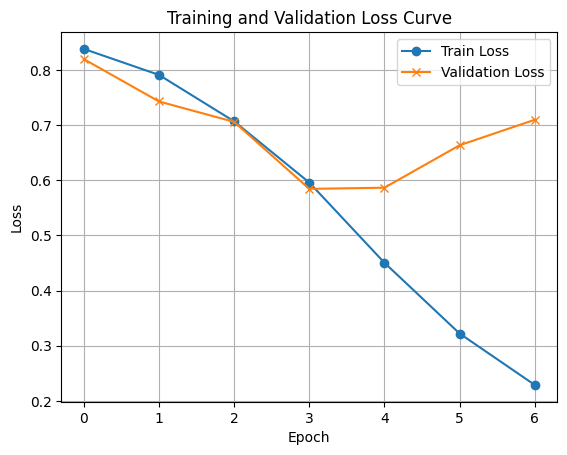

In [27]:
# === Early Stopping Configuration ===
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None

# === Track losses ===
train_losses = []
val_losses = []

# === Training loop ===
epochs = 30  # Set higher value since early stopping is used
for epoch in range(epochs):
    # === TRAINING ===
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # === Early Stopping Check ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

# === Load Best Model ===
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded with val loss: {best_val_loss:.4f}")

# === Save Best Model ===
model.save_pretrained("./finetuned_roberta_model")
tokenizer.save_pretrained("./finetuned_roberta_model")

# === Plot Loss Curve ===
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.grid(True)
plt.show()